# Introduction
We have recieved dataset containing information phishing URLs. Dataset contains list of URLs, URL has SSL, URL allows SQL injection, URL have cert ver, URL allows inp val and whether URL is UNSAFE or not. We'll be dividing dataset into train, validation and test sets. Train set will be used for training and validation set for validation of trained model. We'll then use test set for testing once whole model has completed training.

We'll be trying LSTM and Dense Net for our purpose. We'll first tokenize data using various stratgies like count vectorizer, tfidf, frequency of words etc. We also have used first layer as embedding layer for our LSTM model to create embedding for words.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image ## Library for loading images

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


# Loading & Cleaning Data
We have loaded data in pandas dataframe and then we remove all rows which has any NAN to avoid issues during training.

In [2]:
df = pd.read_csv('/kaggle/input/phishing-latest/csv_result-Phishing_Legitimate_full.csv') ## Change here based on where is file on your local
df = df.dropna() ## Here we are removing any rows which has NaNs. We can't train model with Nan values else it'll fail.
print(df.shape)
df.head() ## Printing first 5 columns of dataset

(10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [3]:
df.tail() ## Printing last 5 columns of dataset.

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
9995,9996,3,1,1,50,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,9997,2,1,4,59,1,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,9998,2,1,4,57,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,9999,3,1,1,49,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
9999,10000,3,1,2,52,3,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0


# Splitting Dataset into Train/Test Sets

In [4]:
df = df.dropna()
X = df.drop(['id','CLASS_LABEL'], axis=1).values ## We are taking all columns except id and class_label as features of model.
Y = df[['CLASS_LABEL']].values ## We are taking class label as target variable.

## We are dividing dataset into train and test sets. Here random_state=123 refers to it'll produce same split each making it reproducible.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, stratify=Y, random_state=123) 
print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


Train/Test Sizes :  (8000, 48) (2000, 48) (8000, 1) (2000, 1)


# LSTM Model Creation
Below we have defined our first LSTM model. Our model consist of 2 layers(LSTM & Dense). LSTM layers consist of 32 units. Here units generally refers to that many nodes in that layers. Dropout are introduced to prevent model from overfitting. Dropout of 0.2 ignores 20% of outputs and set them to 0 before giving it as input to next layer. Dense layer consist of 1 unit with activation function as sigmoid which will transfer LSTM’s output in range (0,1.0) which is probability of that sample. Probability >0.5 will predict output as 1 and <=0.5 will predict output as 0. 

LSTM layer’s units are used to store stateful information in it. We have kept 32 units which will help it store information. Due to 32 units, it requires 10,368 parameters which are calculated as follows. ((input_size + units + 1) * input_size) * 4 = ((48 + 32 + 1 )*32) * 4 = 10,386. Here parameters refers to that many weights will be trained for layer to store information.

Dense layer is simple linear layer which has 33 parameter and single output. Sigmoid activation function transfers output of LSTM from shape of (batch_size,33) to (batch_size,1) which is 1 prediction for all samples of batch. Here Dense layer has 33 parameters because it takes as input 32 units of LSTM layer and 1 bias parameter. 

Total Parameters are LSTM + Dense = 10,386 + 33 = 10,401
All parameters are trainable. We don’t have singel parameter which does not need training. We need to train all.

Below we have printed summary of our model which shows layers and their shapes along with parameters that particular layer will train as well as whole model.

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                10368     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________
None


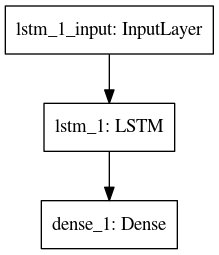

In [5]:
print('Build model...')
model = Sequential([
                    LSTM(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(1,48)),
                    Dense(1, activation='sigmoid')
                   ])
print(model.summary())
plot_model(model, to_file='lstm_model.png')
Image.open('lstm_model.png')

# Compiling Model
Compiling model involes initializing model with which optimizer to use, metrics on which to do evaluation and loss function to calculate loss function.

In [6]:
# try using different optimizers and different optimizer configs
## Binary crossentropy is function which is loss function. Its used for binary problems. For problems with more than 2 class categorical_crossentropy is used.
## Adam is optimizer like SGD but better than SGD in a sense that it adjusts learning rate on its own and keep on improving model performance
## without user changing learnining rate each time and trying.
## Metrics is accuracy which will be printed after each epoch for train and validation sets.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training Model
We'll be training model on train data and taking 10% of that data as validation data for doing evaluation of model performance after each epochs. We have set batch size as 32 samples and epochs as 7. We have reshaped train dataset from (8000,48) to (8000,1,48). We have created just one extra dimension in dataset because its requirement of LSTM model. It expects 3 dimensional data.  Here validation split of 0.1 refers to that 10% of training data will be used as validation set for evaluating model performance during training as well.

In [7]:
%%time

hist = model.fit(X_train.reshape((X_train.shape[0],1,X_train.shape[1])), Y_train, batch_size=32, epochs=7, validation_split=0.1)

Train on 7200 samples, validate on 800 samples
Epoch 1/7
7200/7200 [==============================] - 1s 167us/step - loss: 0.5982 - accuracy: 0.7039 - val_loss: 0.4657 - val_accuracy: 0.8263
Epoch 2/7
7200/7200 [==============================] - 1s 87us/step - loss: 0.4250 - accuracy: 0.8313 - val_loss: 0.2938 - val_accuracy: 0.8963
Epoch 3/7
7200/7200 [==============================] - 1s 88us/step - loss: 0.3287 - accuracy: 0.8692 - val_loss: 0.2354 - val_accuracy: 0.9200
Epoch 4/7
7200/7200 [==============================] - 1s 87us/step - loss: 0.2849 - accuracy: 0.8849 - val_loss: 0.2144 - val_accuracy: 0.9200
Epoch 5/7
7200/7200 [==============================] - 1s 87us/step - loss: 0.2696 - accuracy: 0.8918 - val_loss: 0.2039 - val_accuracy: 0.9187
Epoch 6/7
7200/7200 [==============================] - 1s 88us/step - loss: 0.2615 - accuracy: 0.8928 - val_loss: 0.1825 - val_accuracy: 0.9375
Epoch 7/7
7200/7200 [==============================] - 1s 88us/step - loss: 0.2550 - acc

# Evaluaing Model on Test Data.
Below we are evaluating model performance on test data after training. Please make a note that here also we have changed dimensions of test data to make it suitable for LSTM model.

In [8]:
loss, acc = model.evaluate(X_test.reshape((X_test.shape[0],1,X_test.shape[1])), Y_test, batch_size=64)
preds = model.predict_classes(X_test.reshape((X_test.shape[0],1,X_test.shape[1])))

print('Test Accuracy : ', accuracy_score(Y_test, preds))
print('Test Loss:', loss)
print('Test accuracy:', acc)

2000/2000 [==============================] - 0s 19us/step
Test Accuracy :  0.9325
Test Loss: 0.1879593227505684
Test accuracy: 0.9325000047683716


# Densenet Model Creation
Below we have defined out deep learning model which consists of only dense layers (linear layers). We have defined 4 dense layers with units 256,128,64 and 1. Here units generally refers to that many nodes in that layers. Input to first layer will be array of shape (batch_size, 48) and it’ll go through all layers. Each layer has activation function as relu (max(val, 0)) which removes negative outputs after each layer performs its operation. Output layer is Dense layer with sigmoid function which will transfer output between (0,1.0).  Each layers has parameters which are calculated as follows.

Dense Layer 1 = (input_size * units) + biases = (48 * 256) + 256 = 12,544

Dense Layer 2 = (256 * 128) + 128 = 32,896 ( Please make a note that here input is 256 from Dense Layer 1)

Dense Layer 3 =  (128 * 64) + 64 = 8,256

Dense Layer 4 =  (64 * 1) + 1 = 65


Build model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               12544     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 53,761
Trainable params: 53,761
Non-trainable params: 0
_________________________________________________________________
None


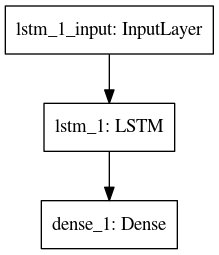

In [9]:
print('Build model...')
dense_model = Sequential( [Dense(256, activation='relu', input_shape=(48,)),
                           Dense(128, activation='relu'),
                           Dense(64,activation='relu'),
                           Dense(1, activation='sigmoid')]
                  )
print(dense_model.summary())
plot_model(model, to_file='dense_model.png')
Image.open('dense_model.png')

# Compile DenseNet

In [10]:
# try using different optimizers and different optimizer configs
# try using different optimizers and different optimizer configs
## Binary crossentropy is function which is loss function. Its used for binary problems. For problems with more than 2 class categorical_crossentropy is used.
## Adam is optimizer like SGD but better than SGD in a sense that it adjusts learning rate on its own and keep on improving model performance
## without user changing learnining rate each time and trying.
## Metrics is accuracy which will be printed after each epoch for train and validation sets.
dense_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training Model
We'll be training model on train data and taking 10% of that data as validation data for doing evaluation of model performance after each epochs. We have set batch size as 32 samples and epochs as 5.

In [11]:
%%time

hist = dense_model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_split=0.1)

Train on 7200 samples, validate on 800 samples
Epoch 1/5
7200/7200 [==============================] - 1s 108us/step - loss: 0.3742 - accuracy: 0.8383 - val_loss: 0.2090 - val_accuracy: 0.9275
Epoch 2/5
7200/7200 [==============================] - 1s 72us/step - loss: 0.1993 - accuracy: 0.9253 - val_loss: 0.1947 - val_accuracy: 0.9225
Epoch 3/5
7200/7200 [==============================] - 1s 73us/step - loss: 0.1767 - accuracy: 0.9353 - val_loss: 0.2109 - val_accuracy: 0.9162
Epoch 4/5
7200/7200 [==============================] - 1s 72us/step - loss: 0.1642 - accuracy: 0.9390 - val_loss: 0.1831 - val_accuracy: 0.9325
Epoch 5/5
7200/7200 [==============================] - 1s 73us/step - loss: 0.1467 - accuracy: 0.9456 - val_loss: 0.1981 - val_accuracy: 0.9250
CPU times: user 6.09 s, sys: 1 s, total: 7.09 s
Wall time: 3.83 s


# Evaluaing Model on Test Data.

In [12]:
loss, acc = dense_model.evaluate(X_test, Y_test, batch_size=64)
preds = dense_model.predict_classes(X_test)

print('Test Accuracy : ', accuracy_score(Y_test, preds))
print('Test Loss:', loss)
print('Test accuracy:', acc)

2000/2000 [==============================] - 0s 16us/step
Test Accuracy :  0.927
Test Loss: 0.1945007069706917
Test accuracy: 0.9269999861717224
